In [ ]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from lightfm import LightFM
from lightfm.data import Dataset

from nltk.tokenize import WordPunctTokenizer
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')

np.random.seed(42)

## Коллаборативный подход

### Загрузка данных

In [2]:
%mkdir data

In [3]:
%cd data

In [4]:
!gdown --folder https://drive.google.com/drive/folders/1gBBoOUD7fWmnyoLhWrC3t33yt6df32m3

In [5]:
%cd ..

In [6]:
raw = pd.read_csv('data/rating.csv')
raw.sample(3)

,userId,movieId,rating,timestamp
17679788,122270,8360,3.5,2012-04-22 01:07:04
7106385,49018,32,2.0,2001-09-11 07:50:36
12970708,89527,109374,3.5,2015-01-06 09:26:40


### EDA

Для начала удалим не нужную в данной задаче колонку - `timestamp`.

In [7]:
raw = raw.drop(columns=['timestamp'])

Проверим, что тип данных уже такой, какой нужно (то есть числовые данные имеют числовой тип):

In [8]:
raw.dtypes

userId       int64
movieId      int64
rating     float64
dtype: object

Проверим, есть ли в данных пропущенные значения:

In [9]:
is_nan = raw.isna().any().any()
if is_nan:
    print('В данных есть пропуски')
else:
    print('В данных нет пропусков')

В данных нет пропусков


**Обработка userId и movieId**

Заметим, что есть фильмы, которые вообще не представлены в наших данных:

In [10]:
raw.movieId.max(), raw.movieId.nunique()

(131262, 26744)

Значит, имеет смысл перенумеровать `movieId` так, чтобы не было пропущенных индексов. Тогда максимальное значение в этой колонке станет меньше - так нам будет проще получить в матрице оценок пользователь-фильм и в матрице скрытых признаков пользователей размерность меньше.

In [11]:
# сохраним реальный максимум movieId на будущее
MOVIE_MAX = raw.movieId.max()
# перенумеруем
# мотивация использования value_counts приведена ниже
sorted_movies = raw.movieId.value_counts().index
new_movies = {movie:i for i, movie in enumerate(sorted_movies)}
raw.movieId = raw.movieId.map(new_movies)

Давайте так же уменьшим количество используемых данных. Идея в следующем: пусть у нас есть пользователи, которые оценили мало фильмов. Матрица оценок пользователь-фильм для этих пользователей будет разреженной. Допустим, мы используем коллаборативный подход, модель со скрытыми признаками. Чтобы добиться большого количества нулевых предсказаний для конкретного пользователя, его вектор скрытых признаков должен быть близок к нулевому. Но в таком случае, в принципе для любого фильма предсказание будет около нуля.

То же самое относится к фильмам, которые мало кто оценил. Предсказания пользователей для таких фильмов будут около нуля, а значит, может так получиться, что они вообще не будут рекомендоваться.

Давайте возьмем таких пользователей, которые оставили хотя бы 1000 оценок, и такие фильмы, которые оценили хотя бы 1000 пользователей.

Для этого воспользуемся возможностями `pandas`: `.value_counts()` с параметрами по умолчанию сортирует вывод в порядке убывания количества встречаний. Тогда мы можем перенумеровать `movieId` и `userId` так, чтобы 0 соответствовал самому часто встречаемому номеру, а максимальное значение - самому редкому. Так, нам останется лишь взять все строки с `userId` < 1000 и `movieId` < 1000.

In [12]:
# movieId мы уже перенумеровали, как надо
# перенумеруем userId
sorted_users = raw.userId.value_counts().index
new_users = {user:i for i, user in enumerate(sorted_users)}
raw.userId = raw.userId.map(new_users)

In [13]:
raw = raw[raw.userId.isin(range(1000)) & raw.movieId.isin(range(1000))]

### Метрика

Для начала заметим, что регрессионные метрики (MAE, MSE и т.п.) не подходят к нашей задаче, поскольку наша цель не предсказать сами значения рейтинга, а правильно упорядочить фильмы в порядке предпочтений пользователя.

Поэтому быдем использовать метрику $nDCG@k$, усредненную по рассматриваемым пользователям.

- Эта метрика решает проблему регрессионных метрик в таких задач, учитывая не сами предсказанные значения, а их порядок.

- Эту метрику можно назвать интерпретируемой, она принимает значения от 0 до 1, где 1 - идеальные предсказания.

- $DCG@k$ при учете релевантность объекта учитывает также его порядок: чем ближе объект к началу, тем важнее его релевантность.

In [14]:
def ndcg_k(user_scores, user_true, k):
    '''
    Compute nDCG@k metric for specific user
    
    user_scores: np.array
        predicted scores for all considered movies of specific user
    user_true: np.array
        true ratings this user gave
    k: int
        number of top-rated movies to consider in DCG@k evaluation
    '''
    dcg_k = 0.
    ideal = 0.
    if k > user_scores.shape[0]:
        k = user_scores.shape[0]
    
    for _k in range(1, k + 1):
        kth = np.argsort(-user_scores)[_k]
        dcg_k += (2 ** (user_true[kth] > 0) - 1) / np.log2(_k + 1)
        ideal += 1 / np.log2(_k + 1)
    
    return dcg_k / ideal

def mean_ndcg(predictions, true_scores, k):
    '''
    Compute mean over users nDCG@k metric
    
    predictions: np.array
        predicted scores of size (n_user x n_movies)
    true_scores: np.array
        true ratings of size (n_user x n_movies)
    k: int
        'k' parameter in nDCG@k metric
    '''
    dcg_sum = 0.
    for i in range(predictions.shape[0]):
        dcg_sum += ndcg_k(predictions[i], true_scores[i], k)
    return dcg_sum / predictions.shape[0]

### Разбиение данных

Идея заключается в следующем: будем разбивать данные так, чтобы в обучающей выборке у нас была информацию о каждом пользователе и каждом фильме. 

Таким образом, в валидационной и тестовой выборках у нас не будет новых пользователей и новых фильмов, а значит мы сможем избежать проблему холодного старта.

**Метод разбиения**

- Для каждого уникального значения `userId` получаем по одной строке

- Аналогично для `movieId`

- Объединяем индексы этих строк. Под-датафрейм по этим индексам будет содержать по одному вхождению каждого уникального значения `userId` и `movieId`. Этот под-датафрейм пойдет в обучающую выборку.

In [15]:
user_ind = set(raw.groupby('userId').head(1).index)
movie_ind = set(raw.groupby('movieId').head(1).index)

ind = sorted(list(user_ind.union(movie_ind)))

- Теперь разбивать стандартным способом мы будет датафрейм без этих строк. Пусть мы хотим разбить исходные данные на обучающую, отложенную и тестовую выборки в соотношении 8/1/1 (0.8 от исходных данных/0.1/0.1). Но у нас уже есть какое-то количество пар пользователь-фильм, которые гарантировано являются частью обучающей выборки. Тогда нам нужно посчитать, какую часть от исходной выборки нужно добавить в обучающую, чтобы в итоге получилось ~0.8 от исходных данных.

In [16]:
train_size = 0.8 - (len(ind) / raw.shape[0])

- Получаем исходные данные без выбранных раннее строк. Их разбиваем с помощью метода `train_test_split`: сначала отделяем от данных ту часть, которая пойдет в обучающую выборку, а затем оставшиеся данные (это ~0.2 от исходных данных) разбиваем на две половинки, валидационную и тестовую выборки.

In [17]:
raw_resid = raw.loc[~raw.index.isin(ind)]

In [18]:
train, test_val = train_test_split(raw_resid, train_size=train_size, random_state=42)
val, test = train_test_split(test_val, test_size=0.5, random_state=42)

- Объединяем две части обучающей выборки и перемешиваем.

In [19]:
train = pd.concat((train, raw.loc[raw.index.isin(ind)])).sample(frac=1, random_state=42)

Проверим, что исходные данные разделены в желаемом соотношении:

In [20]:
tr = train.shape[0] / raw.shape[0]
tt = test.shape[0] / raw.shape[0]
vl = val.shape[0] / raw.shape[0]

print(f'Обучающая выборка: {tr}\nВалидационная выборка: {vl}\nТестовая выборка: {tt}')

Обучающая выборка: 0.797459413436058
Валидационная выборка: 0.10126949606012967
Тестовая выборка: 0.10127109050381232


### Модель

Для коллаборативного подхода будем использовать модель со крытыми переменными. Метод получения матриц скрытых признаков - $ALS$. Реализуем:

In [21]:
class ALS:
    def __init__(
        self, lambda_u=0.5, lambda_m=0.5, hidden_size=10, max_iter=100, plot_history=False, tqdm_silence=True
    ):
        '''
        Class for conducting collaborative filtering with ALS optimization
        
        lambda_u: float
            regularization strength for user features
        lambda_m: float
            regularization strength for movie features
        hidden_size: int
            number of features (for both user and movie features)
        max_iter: int
            number of iterations of ALS optimization
        plot_history: bool
            if True, plot loss and metrics history after training
        tqdm_silence: bool
            if True, silence tqdm output during training
        '''
        self.lambda_u = lambda_u
        self.lambda_m = lambda_m
        self.hidden_size = hidden_size
        self.max_iter = max_iter
        self.plot_history = plot_history
        self.tqdm_silence = tqdm_silence
        # define matrices
        self.U = None
        self.M = None
        self.r_sparce = None
        # prepare history storage if needed
        if self.plot_history:
            # define things for ndcg@k
            self.k_range = [5, 10, 100]
            self.metric_history = {}
            for k in self.k_range:
                self.metric_history[k] = []
            self.losses = []
    
    def plot(self):
        '''
        Plot loss and metrics history
        
        losses: iterable
            contains loss/metric/etc. after each iteration of training
        '''
        fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
        
        # Loss
        axs[0].plot(np.arange(self.max_iter) + 1, self.losses)
        axs[0].set_title('Ошибка ALS во время обучения', fontsize=16)
        axs[0].set_ylabel('Функция потерь')
        axs[0].set_xlabel('Итерация ALS')
        
        # Metrcis
        for k in self.k_range:
            axs[1].plot(np.arange(self.max_iter) + 1, self.metric_history[k], label=f'k = {k}')
        axs[1].set_title('Значения метрики во время обучения', fontsize=16)
        axs[1].set_ylabel('Mean nDCG@k')
        axs[1].set_xlabel('Итерация ALS')
        axs[1].legend(title='Параметр k метрики nDCG@k')
        
        plt.tight_layout()
    
    def fit(self, train):
        '''
        Fit model and conduct ALS optimization
        
        train: pd.DataFrame
            training data for the task,
            should contain columns 'userId', 'movieId', 'rating',
            'userId' and 'movieId' should start with 0
        '''
        # extract ratings into sparse matrix
        user_size = train.userId.max() + 1
        movie_size = train.movieId.max() + 1

        ratings = train.rating
        self.r_sparse = sparse.csr_matrix(
            (ratings, (train.userId, train.movieId)),
            shape=(user_size, movie_size)
        )
        # create matrices of user and movie features
        # random pre-initialization
        self.U = np.random.normal(size=(user_size, self.hidden_size))
        self.M = np.random.normal(size=(movie_size, self.hidden_size))

        for i in tqdm(range(self.max_iter), desc='Training', disable=self.tqdm_silence, ncols=80):
            # identity matrix
            EYE = np.eye(self.hidden_size)
                
            # update feature matrices
            self.U = self.r_sparse * self.M @ np.linalg.inv(self.M.T @ self.M + self.lambda_u * EYE)
            self.M = self.r_sparse.T * self.U @ np.linalg.inv(self.U.T @ self.U + self.lambda_m * EYE)
            
            # history
            if self.plot_history:
                self.get_loss()
                self.get_metric(train)
        
        if self.plot_history:
            self.plot()
        
        return self
    
    def get_loss(self):
        '''
        Compute and store ALS loss
        '''
        self.losses.append(
            np.sum((self.r_sparse.toarray() - self.U @ self.M.T) ** 2) +\
            self.lambda_u * np.linalg.norm(self.U, ord=2, axis=1) +\
            self.lambda_m * np.linalg.norm(self.M, ord=2, axis=1)
        )
    
    def get_metric(self, data):
        '''
        Compute and store nDCG@k, where k takes values in some range
        
        data: pd.DataFrame
            data to compute metrics for,
            should contain columns 'userId', 'movieId', 'rating',
            'userId' and 'movieId' should start with 0
        '''
        true_scores = data.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0.)
        u = true_scores.index.values
        m = true_scores.columns.values
        for k in self.k_range:
            self.metric_history[k].append(
                mean_ndcg(self.predict_scores(u, m), true_scores.values, k)
            )
    
    def predict_scores(self, user_ids, movie_ids):
        '''
        Compute matrix of scores for given sequences of users and movies
        
        user_ids: list or np.array
            IDs of users
        movie_ids: list or np.array
            IDs of movies
        '''
        return self.U[user_ids] @ self.M[movie_ids].T
        
    def predict(self, user_ids, movie_ids):
        '''
        Predict ratings for user-movie pairs
        
        user_ids: list or np.array
            IDs of users
        movie_ids: list or np.array
            IDs of movies
        '''
        preds = []
        for u, m in zip(user_ids, movie_ids):
            preds.append(model.U[u] @ model.M[m])
        return preds

Проверим, что все работает.

In [22]:
model = ALS(hidden_size=10, max_iter=5, plot_history=True, tqdm_silence=False)

Training: 100%|███████████████████████████████████| 5/5 [00:21<00:00,  4.38s/it]


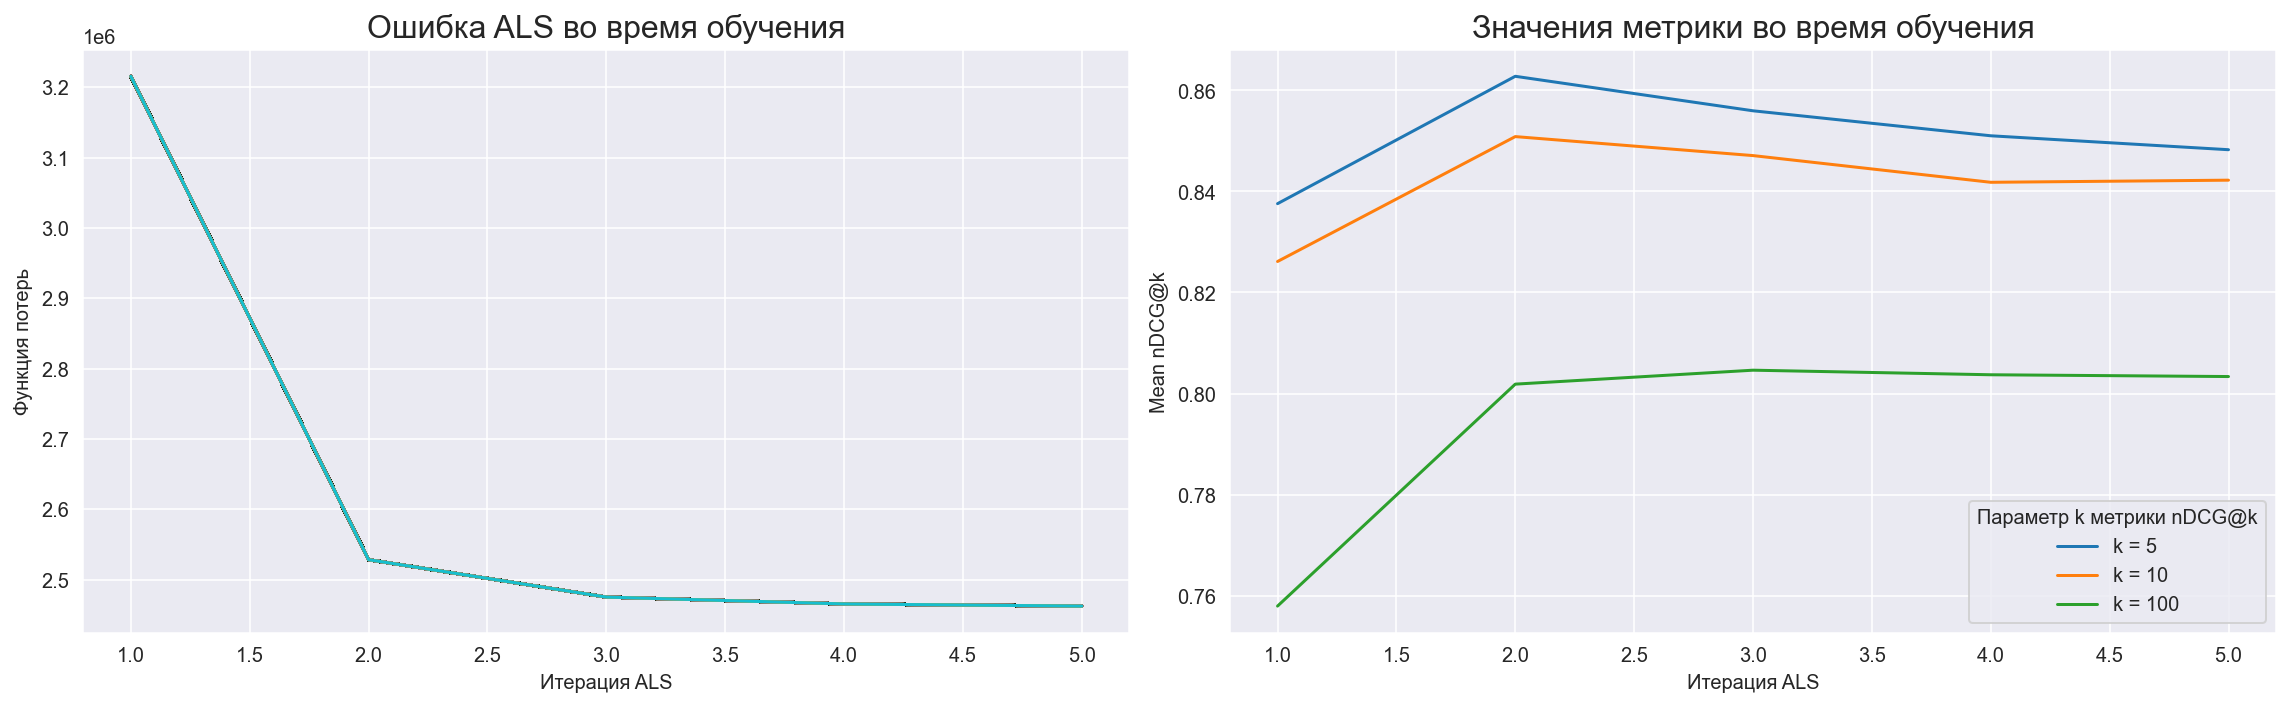

In [23]:
model.fit(train)

**Подбор гиперпараметров**

Подберем гиперпараметры с помощью валидации по отложенной выборке.

In [24]:
def compute_metric_ALS(model, data, k):
    '''
    Compute mean nDCG@k for model with ALS optimization
    
    model: instance of ALS class
        model to obtain predictions with
    data: pd.DataFrame
        data to compute metrics for,
        should contain columns 'userId', 'movieId', 'rating',
        'userId' and 'movieId' should start with 0
    k: int
        k parameter of nDCG@k metric
    '''
    true_scores = data.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0.)
    u = true_scores.index.values - 1
    m = true_scores.columns.values - 1
    predicts = model.U[u] @ model.M[m].T
    
    return mean_ndcg(predicts, true_scores.values, k)

In [25]:
lambda_range = np.logspace(-2, 1, num=10)
hs_range = [5, 10, 20, 100, 500, 1000]
max_iter_range = [5, 10, 20, 100]

best_params = {
    'lambda': 0.,
    'hidden_size': 0,
    'max_iter': 0
}
best_metric = 0.

for lambda_ in tqdm(lambda_range, desc='Validating', ncols=80):
    for hidden_size in hs_range:
        for max_iter in max_iter_range:
            model = ALS(
                lambda_u=lambda_,
                lambda_m=lambda_,
                hidden_size=hidden_size,
                max_iter=max_iter
            )
            model.fit(train)
            metric = compute_metric_ALS(model, val, 10)
            if metric > best_metric:
                best_metric = metric
                best_params['lambda'] = lambda_
                best_params['hidden_size'] = hidden_size
                best_params['max_iter'] = max_iter

Validating: 100%|██████████████████████████████| 10/10 [21:19<00:00, 127.91s/it]


In [26]:
print(best_params)

{'lambda': 0.046415888336127774, 'hidden_size': 5, 'max_iter': 20}


In [27]:
best_metric

0.08826999266279101

In [28]:
# чтобы не запускать подбор

# best_params = {'lambda': 0.046415888336127774, 'hidden_size': 5, 'max_iter': 20}

In [29]:
best_als = ALS(
    lambda_u = best_params['lambda'],
    lambda_m = best_params['lambda'],
    hidden_size=best_params['hidden_size'], 
    max_iter=best_params['max_iter']
)

## Коллаборативный  + контентный подход

### Загрузка и предобработка данных

Для начала получим упорядоченную последовательность всех возможных `movieId`. С ее помощью нам будет удобно реиндексировать данные для фильмов.

In [30]:
ind = np.arange(MOVIE_MAX) + 1

Для того, чтобы получить векторные представления признаков фильмов, которые будут подаваться `LightFM` во время обучения и предсказания, будем использовать `Dataset` из библиотеки `lightfm`.

Чтобы создать датасет, для каждого признака нам нужно будет получить все его уникальные значения, сохранить их в формате `{название признака:значение}`.

### tags.csv

In [31]:
tags = pd.read_csv('data/tag.csv')
tags.sample(3)

,userId,movieId,tag,timestamp
380178,119367,58559,Christian Bale,2009-05-12 02:52:15
292553,88738,899,vocalists,2009-07-04 19:23:55
740,348,69951,new,2010-01-07 22:01:29


Это данные про то, какую текстовую метку пользователь сопоставил фильму.

Поскольку одному фильму может быть сопоставлено несколько пользовательских меток, то можно обработать их так: каждому фильму будет соспоставлена последовательность из 0 и 1, где на i-ом месте стоит 1, если i-ая метка была поставлена фильму, и 0 иначе.

In [32]:
tags.tag.nunique()

38643

Видим, что пользовательских меток много, особенно в сравнении с количеством рассматриваемых фильмов (их 1000). Таким образом, данные о пользовательских метках будут разрежены. Из таких данных модели сложнее получить какую-то ценную информацию, и она более склонна к переобучению.

Поэтому **tags.csv** мы использовать не будем.

### movie.csv

In [33]:
movie = pd.read_csv('data/movie.csv')
movie.sample(3, random_state=154)

,movieId,title,genres
23708,112753,Torment (2013),Horror|Thriller
12936,61253,"Longshots, The (2008)",Drama
27027,129887,Moving Alan,(no genres listed)


В этих данных фильму сопоставлены два типа текстовой информации: название и список жанров.

**Жанры**

Каждому фильму может соответсвовать несколько жанров. Обработаем эти данные так, чтобы каждому фильму соответствовала последовательность из 0 и 1, где 1 означает, что соответсвующий жанр соответсвует этому фильму. 

In [34]:
movie_features = movie.set_index('movieId').genres.str.split('|', expand=True).replace(
    {'(no genres listed)': None}).stack().reset_index().pivot_table(
    index='movieId', columns=0, fill_value=0, aggfunc='size').rename_axis(None, axis=0).reindex(ind, fill_value=0)

In [35]:
movie_features.head(3)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


**Название**

Название сохраним без дополнительной предобработки.

In [36]:
movie_features['title'] = movie.set_index('movieId').title.reindex(ind).fillna('')

### links.csv

In [37]:
links = pd.read_csv('data/link.csv')
links.sample(3)

,movieId,imdbId,tmdbId
10488,38881,67633,26513.0
19154,95199,1586265,76494.0
655,663,116768,18414.0


Эти числовые данные тоже добавим без предобработки.

In [38]:
movie_features['imdbId'] = links.set_index('movieId').reindex(ind).fillna(0).imdbId
movie_features['tmdbId'] = links.set_index('movieId').reindex(ind).fillna(0).tmdbId

### genome_scores.csv & genome_tags.csv

In [39]:
genome_scores = pd.read_csv('data/genome_scores.csv')
genome_scores.sample(3)

,movieId,tagId,relevance
7462588,8622,869,0.06875
3190507,3182,524,0.18725
6182316,6428,877,0.06975


In [40]:
genome_tags = pd.read_csv('data/genome_tags.csv')
genome_tags.sample(3)

,tagId,tag
273,274,cult
752,753,oscar (best foreign language film)
76,77,artificial intelligence


В первой табличке хранится информация о том, насколько некоторая метка подходит к некоторому фильму. Во второй - текстовые описания этих меток.

Хочется учесть не только релевантность меток, но и их описания.

Для каждой метки мы можем получить векторное представление текстового описания. А чтобы получить информацию о фильмах, мы можем для каждого фильма посчитать взвешенную сумму векторных представлений меток, где веса - коэффициенты `relevance` из первой таблички.

Векторные представления текстовых описаний получим так:

- Токенизируем текст

- Получим векторной представление каждого токена с помощью Word2Vec

- Для каждой метки получим векторное представление, усреднив W2V по всем токенам

In [41]:
def mean(embeddings, embed_size):
    '''
    Mean over sequnce of embeddings
    aiming to control empty sequences
    
    embeddings: np.array
        sequnce of embeddings
    embed_size: int
        dimesion of embeddings space
    '''
    if not len(embeddings):
        return np.zeros(embed_size)
    return np.mean(embeddings, axis=0)

def get_embeddings(text_data, embed_size):
    '''
    Get embeddings of textual feature
    
    text_data: pd.Series
        textual feature,
        length should be equal to maximum movieID
    embed_size: int
        dimesion of embeddings space
    '''
    # lower case + tokenization
    tokenizer = WordPunctTokenizer()
    tokenized = list(map(tokenizer.tokenize, list(map(str.lower, text_data.values))))
    # fit W2V
    model = Word2Vec(tokenized, vector_size=embed_size, min_count=1, window=5).wv
    # compute mean embedding for every movie
    return np.array([mean(
        np.array(list(map(model.get_vector, seq))),
        embed_size) for seq in tokenized])

In [42]:
EMBED_SIZE=32
g_tags = get_embeddings(
    genome_tags.set_index('tagId').tag.reindex(np.arange(genome_scores.tagId.max()) + 1).fillna(''),
    EMBED_SIZE
)

Чтобы было удобнее считать взвешенную сумму, преобразуем первую табличку в табличку формата (n_movies x n_tags), где на (i, j) месте будет `relevance` j-ой метки по отношению к i-ому фильму.

In [43]:
g_rel = genome_scores.pivot_table(
    index='movieId', columns='tagId', values='relevance', fill_value=0
).reindex(ind).fillna(0).sort_index(axis=1)
g_rel.head(3)

tagId,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02500,0.02500,0.05775,0.09675,0.14675,0.2170,0.06700,0.26275,0.26200,0.03200,...,0.03950,0.01800,0.04575,0.03275,0.1250,0.04150,0.01925,0.03625,0.07775,0.02300
2,0.03975,0.04375,0.03775,0.04800,0.11025,0.0725,0.04775,0.10975,0.09925,0.02050,...,0.04175,0.01925,0.01725,0.02425,0.1255,0.02250,0.01550,0.01475,0.09025,0.01875
3,0.04350,0.05475,0.02800,0.07700,0.05400,0.0685,0.05600,0.18500,0.04925,0.02675,...,0.04150,0.02675,0.02775,0.03425,0.1555,0.03675,0.01700,0.01950,0.09700,0.01850


Теперь взвешенная сумма векторных представлений меток - это просто матричное произведение матрицы весов на матрицу векторных представлений. Добавим это в нашу таблицу признаков.

In [44]:
movie_features = pd.concat((
    movie_features,
    g_rel @ g_tags
), axis=1)

Итого:

In [45]:
movie_features

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,22,23,24,25,26,27,28,29,30,31
1,0,1,1,1,1,0,0,0,1,0,...,0.378041,-0.041499,-0.165632,-0.164631,-0.193850,-0.144911,-0.067228,-0.226316,-0.118943,0.146792
2,0,1,0,1,0,0,0,0,1,0,...,0.219363,0.041798,-0.162652,-0.177201,-0.187337,-0.028217,-0.162851,-0.251472,-0.015372,0.020435
3,0,0,0,0,1,0,0,0,0,0,...,0.212934,-0.103764,-0.166946,-0.089485,-0.139654,0.026715,-0.053008,-0.150483,-0.102074,0.048749
4,0,0,0,0,1,0,0,1,0,0,...,0.184004,-0.039083,-0.099163,-0.027738,-0.084109,-0.150266,-0.041643,-0.059041,-0.095118,0.056699
5,0,0,0,0,1,0,0,0,0,0,...,0.099856,-0.034813,-0.167926,-0.017261,-0.190554,0.005475,-0.108558,-0.145421,-0.062994,-0.023387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131258,0,1,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
131259,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
131260,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
131261,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Обработка movieId

Предобрабатывая данные о рейтингах, мы оставили лишь часть фильмов и перенумеровали их. Нужно учесть это и для признаков фильмов.

Признаки мы получили для всех `movieId` от 1 до максимально возможного. Но в данных о рейтингах у нас были не все индексы, и мы перенумеровывали только их.

- Сначала найдем те `movieId`, которых не хватало во время обработки рейтингов

- Добавим эти индексы в конец `sorted_movies` - здесь у нас хранятся `movieId`, отсортированные в порядке убывания количества встречаний. Поскольку мы все равно возьмем лишь 1000 самых часто встречаемых, добавление в конец не повлияет на то, какие `movieId` будут отобраны. Но зато так мы сможем перенумеровать индексы таблицы с признаками.

In [46]:
missing_movies = list(set(ind) - set(sorted_movies))
to_reindex = np.append(sorted_movies, missing_movies)
reindexed_movies = {movie:i for i, movie in enumerate(to_reindex)}
movie_features.index = movie_features.index.map(reindexed_movies)

Осталось отобрать 1000 самых часто втречаемых фильмов.

In [47]:
movie_features = movie_features.sort_index(axis=0).iloc[:1000]

In [48]:
movie_features

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,22,23,24,25,26,27,28,29,30,31
0,0,0,0,0,1,1,0,1,0,0,...,0.461430,-0.442967,-0.112871,-0.182435,-0.075205,-0.098101,-0.064770,-0.154940,-0.110693,0.137927
1,0,0,0,0,1,0,0,1,0,0,...,0.573309,-0.296778,0.031021,-0.253100,-0.315250,-0.224382,-0.029766,-0.206342,-0.039836,0.156650
2,0,0,0,0,0,1,0,1,0,0,...,0.576834,-0.358651,0.055019,-0.233320,-0.234182,-0.108255,0.014788,-0.184270,-0.016779,0.141563
3,0,0,0,0,0,1,0,0,0,0,...,0.506337,-0.355207,-0.001690,-0.132096,-0.120268,0.000329,0.000885,-0.065815,0.000498,0.146046
4,1,1,0,0,0,0,0,0,0,0,...,0.424172,-0.213215,-0.120499,-0.165570,-0.225660,-0.077882,-0.052508,-0.278858,0.075529,0.237754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,0,0,0,1,0,1,0,0,...,0.338458,-0.169114,-0.021639,-0.214792,-0.066838,-0.032403,-0.070723,-0.116561,-0.154069,-0.074526
996,1,1,0,0,0,0,0,0,0,0,...,0.300453,-0.172802,-0.118012,-0.223630,-0.144923,-0.062521,0.006981,-0.137668,-0.062990,0.116311
997,0,0,0,0,1,0,0,0,0,0,...,0.300647,-0.130017,0.008896,-0.055241,-0.154558,-0.040650,0.006922,-0.047055,-0.103085,0.071231
998,0,0,0,0,1,1,0,0,0,0,...,0.321576,-0.221961,-0.030918,-0.119871,-0.172183,-0.011924,-0.030645,-0.142796,-0.068528,0.000469


### LightFM

Сначала подготовим матрицу оценок размера (количество пользователей x количество фильмов).

In [49]:
# мы строили обучающую выборку так, что в ней есть все фильмы и все зрители
# значит из нее мы можем получить глобальные макимальные значения movieId и userId
user_size = train.userId.max() + 1
movie_size = train.movieId.max() + 1

ratings = train.rating
r_sparse = sparse.csr_matrix(
    (ratings, (train.userId, train.movieId)),
    shape=(user_size, movie_size)
)

Теперь получим признаки фильмов. Подготовим датасет.

In [50]:
dataset = Dataset()

Получим значения признаков в формате `название признака:значение`:

In [51]:
features = []

for column in movie_features.columns:
    feature_values = movie_features[column].unique()
    features += list(map(lambda v: str(column) + ':' + str(v), feature_values))
features[:2]

['Action:0', 'Action:1']

Теперь мы можем построить датасет на наших данных:

In [52]:
dataset.fit(
        users=np.arange(user_size),
        items=np.arange(movie_size),
        item_features=features
)

Чтобы получить признаки фильмов из датасета, нам нужно для каждого фильма получить информацию о значениях признаков в формате: `(индекс фильма, [название признака:значение])`

In [53]:
def get_features_for_movie(feature_values):
    '''
    For specific movie, get feature values of format (movieId:['feature_name:value'])
    
    feature_values: iterable
        sequnce of feature values of specific movie,
        i-th value should correspond to i-th feature in feature-DataFrame
    '''
    features = []
    columns = movie_features.columns
    
    for i in range(len(feature_values)):
        features += [str(columns[i]) + ':' + str(feature_values[i])]
    return features

def get_features_for_all():
    '''
    For all considered movies, get feature values of format (movieId:['feature_name:value'])
    '''
    res = []
    movie_inds = np.arange(movie_size)
    for ind in movie_inds:
        res += [ (ind, get_features_for_movie(movie_features.iloc[ind].values)) ]
    return res

In [54]:
item_tuples = get_features_for_all()

Теперь получим признаки, которые будем подавать на вход `LightFm`.

In [55]:
item_features = dataset.build_item_features(item_tuples, normalize= False)

**Модель**

Сначала обучим модель, просто чтобы проверить, что она учится. Для этого после каждой итерации обучения будем смотреть на значение метрики nDCG@k.

In [56]:
def compute_metric_LightFM(model, data, k):
    '''
    Compute mean nDCG@k for LightFM model
    
    model: instance of LightFM class
        model to obtain predictions with
    data: pd.DataFrame
        data to compute metrics for,
        should contain columns 'userId', 'movieId', 'rating',
        'userId' and 'movieId' should start with 0
    k: int
        k parameter of nDCG@k metric
    '''
    true_scores = data.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0.)
    u = true_scores.index.values
    m = true_scores.columns.values
    
    n_users = u.shape[0]
    n_movies = m.shape[0]
    u = np.repeat(u, n_movies)
    m = np.tile(m, n_users)
    
    predicts = model.predict(
        user_ids=u, 
        item_ids=m,
        item_features=item_features
    ).reshape(n_users, n_movies)
    
    return mean_ndcg(predicts, true_scores.values, k)

In [57]:
model = LightFM(
    no_components=10,      # hidden size
    loss='warp',           # loss, suitable for non-negative ratings
    learning_rate=1e-3,
    random_state=42
)

In [58]:
EPOCHS = 10

k_range = [5, 10, 100]
metric_history = {}
for k in k_range:
    metric_history[k] = []

for _ in tqdm(range(EPOCHS), desc='Training', ncols=80):
    model.fit_partial(r_sparse,
              item_features=item_features,
              epochs=1,
              verbose=False
    )
    for k in k_range:
        metric_history[k].append(
            compute_metric_LightFM(model, train, k)
        )

Training: 100%|█████████████████████████████████| 10/10 [02:04<00:00, 12.42s/it]


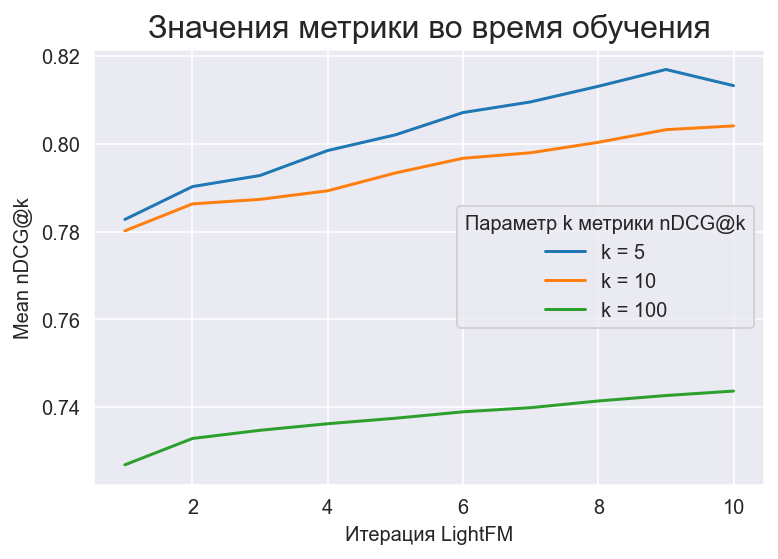

In [59]:
plt.figsize=(8, 5)

for k in k_range:
    plt.plot(np.arange(EPOCHS) + 1, metric_history[k], label=f'k = {k}')
plt.title('Значения метрики во время обучения', fontsize=16)
plt.ylabel('Mean nDCG@k')
plt.xlabel('Итерация LightFM')
plt.legend(title='Параметр k метрики nDCG@k')

plt.show()

**Подбор гиперпараметров**

Подберем гиперпараметры с помощью валидации на отложенной выборке.

In [60]:
hs_range = [5, 10, 20, 100]
max_iter_range = [5, 10, 20, 30]
lr_range = np.logspace(-5, -1, num=5)

best_params = {
    'hidden_size': 0,
    'max_iter': 0,
    'lr': 0.
}
best_metric = 0

for lr in tqdm(lr_range, desc='Validating', ncols=80):
    for max_iter in max_iter_range:
        for hidden_size in hs_range:
            model = LightFM(
                no_components=hidden_size,
                loss='warp',
                learning_rate=lr,
                random_state=42
            )
            model.fit(r_sparse,
                      item_features=item_features,
                      epochs=max_iter,
                      verbose=False
            )
            metric = compute_metric_LightFM(model, val, 10)
            if metric > best_metric:
                best_metric = metric
                best_params['hidden_size'] = hidden_size
                best_params['max_iter'] = max_iter
                best_params['lr'] = lr

Validating: 100%|█████████████████████████████| 5/5 [5:13:07<00:00, 3757.58s/it]


In [61]:
print(best_params)

{'hidden_size': 20, 'max_iter': 5, 'lr': 1e-05}


In [62]:
best_metric

0.09465977299574804

In [63]:
# als: 0.08826999266279101

In [64]:
# чтобы не запускать подбор

# best_metric = {'hidden_size': 20, 'max_iter': 5, 'lr': 1e-05}

In [65]:
best_lightfm = LightFM(
    no_components=best_params['hidden_size'],
    loss='warp',
    learning_rate=best_params['lr'],
    random_state=42
)
best_epochs = best_params['max_iter']

## Сравнение моделей

Сравним лучшие модели обоих подходов, посмотрев на их качество на тестовой выборке.

In [66]:
best_als.fit(train)
als_metric = compute_metric_ALS(best_als, test, 10)

In [67]:
best_lightfm.fit(r_sparse, item_features=item_features, epochs=best_epochs, verbose=False)
lightfm_metric = compute_metric_LightFM(best_lightfm, test, 10)

In [68]:
print(f'Качество \'ALS\' на тестовой выборке: {als_metric}\nКачество LightFM на тестовой выборке: {lightfm_metric}')

Качество 'ALS' на тестовой выборке: 0.08705106206610179
Качество LightFM на тестовой выборке: 0.08989824468661696


## Выводы

Видим, что в итоге с гибридным подходом получилось добиться лучшего качества на валидационной и тестовой выборках, чем с коллаборативным. Но разница довольно мала (около 0.006 и 0.003 соответственно в терминах усредненной $nDCG@k$), при этом `LightFM` обучается гораздо дольше, чем модель со скрытыми признаками и `ALS` оптимизацией (это особенно заметно, если сравнить время, ушедшее на подбор гиперпараметров).

Таким образом, у обоих подходов есть свои плюсы:

- коллаборативный + контентный подход позволяет добиться лучшего качества, так как модель использует всю имеющуюся информацию

- коллаборативный подход занимает гораздо меньше времени и уступает гибридному подходу сравнительно не сильно

Если имеющиеся вычислительные ресурсы позволяют производить обучение `LightFM` быстрее (например, с помощью параллельности), то это лучшая модель. Она использует все данные, и довольно гибкая - можно контролировать, какие данные о фильмах и в каком виде мы хотим подать модели при обучении.